### Lighting Science Final Project  <br>
Takehiro Izumi, Amrit Shaw, Takuma Tsuruta <br>


Import necesarry librarieas and try to connect the DMX controller and JETI spectroradiometers.

In [66]:
from DMXEnttecPro import Controller
from DMXEnttecPro.utils import get_port_by_serial_number, get_port_by_product_id
import numpy as np
import time
from matplotlib import pyplot as plt
import datetime
import os
import luxpy as lx  # package for color science calculations
from luxpy.toolboxes import spectro as sp
import glob
from luxpy.toolboxes import spdbuild as spb
from serial.tools import list_ports

# port = get_port_by_serial_number('EN279626')
# dmx = Controller(port, dmx_size=256)



# ports = list_ports.comports()  # find available ports
#     for info in ports:
#         print(info.description)
#         print(info.manufacturer)
#         print(info.product)
#         print(info.interface)
#     # find DMX port
#     devices = [info.device for info in ports if 'DMX' in info.description]

cieobs = '1964_10'
try:
    port = get_port_by_product_id(24577)
    dmx = Controller(port)
    sp.init('jeti')
    print("connected")
except:
    dmx = None
    print('no connection')

def dmx_render(r,g,b,w,a,uv=0):
    dmx.set_channel(1, int(r))
    dmx.set_channel(2, int(g))
    dmx.set_channel(3, int(b))
    dmx.set_channel(4, int(w))
    dmx.set_channel(5, int(a))
    dmx.set_channel(6, int(uv))
    dmx.submit()

connected


Turn on the laser pointer in JETI and check the measurement point.

In [67]:
if dmx is not None:
    sp.jeti.set_laser(laser_on=True)
    dmx_render(0,0,0,0,0)
    time.sleep(2)
    sp.jeti.set_laser(laser_on=False)


In [130]:
def calibrate(filename=None):
    if filename is None:
        assert dmx is not None  # if dms is None, return error
        now = datetime.datetime.now()
        filename = './output/data_' + now.strftime('%Y%m%d_%H%M%S')
        if not os.path.exists(os.path.dirname(filename)):
            os.mkdir(os.path.dirname(filename))
        
        channels = [1, 2, 3, 4, 5]

        # dr_value_in = np.arange(0, 255, 10)
        dr_value_in = np.concatenate([np.arange(0, 50, 5), np.arange(50, 255, 10)])

        if dr_value_in[-1] < 255:  # make sure the last output is max.
            dr_value_in = np.append(dr_value_in, 255)

        measured_spd_all = []
        measured_luminance_all = []

        for channel in channels:
            measured_spd = []
            measured_luminance = []
            for c in channels:
                dmx.set_channel(c, 0)
                dmx.submit()

            for v in dr_value_in:
                print(channel, v)
                if dmx is not None:
                    dmx.set_channel(channel, v)
                    dmx.submit()
                    time.sleep(0.2) # wait for changing settings
                # Avoid to measure with 0 output value because JETI can't be used in a dark room.
                if v <= 0:
                    measured_luminance.append(0)
                    measured_spd.append(None)
                else:
                    spd = sp.jeti.get_spd()
                    l = lx.spd_to_power(spd, ptype='pu', cieobs=cieobs)
                    measured_luminance.append(l[0][0])
                    measured_spd.append(spd)

            #  fill None data as zero spectrum
            if measured_spd[0] is None:
                measured_spd[0] = measured_spd[1].copy()
                measured_spd[0][-1] = measured_spd[0][-1]*0
                
            print(measured_luminance)
            measured_spd_all.append(measured_spd)
            measured_luminance_all.append(measured_luminance)

        np.savez(filename, luminance=measured_luminance_all,
                spd=measured_spd_all, dr_value_in=dr_value_in, channels=channels)
        return np.load(filename+'.npz')
    return np.load(filename)
           

      

Calibrate the light source (or load existing calibrate data). <br>
Calculate output-value v.s. output-luminance characteristic using poly fit function. <br>
Show the graphs if specified (is_plot = True).

In [139]:
# f = 'output/data_20230324_163716.npz'
# f = 'output/data_20230420_104200.npz'
# f = None
f = 'output/data_20230424_180235.npz'
is_plot = False
# is_plot = True
data = calibrate(f)



In [141]:

dr_value_in = data['output_values']
channels = data['channels']
measured_luminance_all = data['luminance']
measured_spd_all = data['spd']
labels = ['R', 'G', 'B', 'WH', 'A', 'UV']

normL2output = []
output2L = []
    
for i, channel in enumerate(channels):
    luminance = np.asarray(measured_luminance_all[i])
    spd = measured_spd_all[i]
    luminance = luminance - measured_luminance_all[i][0]
    # normalized_luminance = (luminance-min(luminance)) / (max(luminance)-min(luminance))
    normalized_luminance = luminance / max(luminance)

    z = np.polyfit(luminance, dr_value_in,6)
    z_norm = np.polyfit(normalized_luminance, dr_value_in,6)
    z_inv = np.polyfit(dr_value_in, luminance, 6)

    func = np.poly1d(z)
    func_norm = np.poly1d(z_norm)
    func_inv = np.poly1d(z_inv)

    normL2output.append(func_norm)    
    output2L.append(func_inv)

    if is_plot:
        plt.figure()
        plt.plot(dr_value_in, luminance, '.')
        plt.plot(func(luminance), luminance, '-')
        plt.xlabel('driver value indices')
        plt.ylabel('Luminance [cd/m^2]')
        plt.title(labels[i])
        plt.savefig('output/luminance_output_{}.png'.format(labels[i]))

        plt.figure()
        plt.plot(dr_value_in, normalized_luminance, '.')
        plt.plot(func_norm(normalized_luminance), normalized_luminance, '-')
        plt.xlabel('Output Value')
        plt.ylabel('Normalized Luminance')
        plt.title(labels[i])
        plt.savefig('output/normL_output_{}.png'.format(labels[i]))

        lx.SPD(spd[-1]).plot()
        plt.title(labels[i])
        plt.savefig('output/spd_255_{}.png'.format(labels[i]))


## 3-channels color mixing

In [145]:
def getPrimarySPD(channels_idx):
    spd_p = []
    for c in channels_idx:
        spd = measured_spd_all[c][-1].copy()
        # spd[-1] = spd[-1] - measured_spd_all[c][0][-1]
        spd_p.append(spd)
    return np.vstack([spd_p[0][0]] +
                         [s[-1] for s in spd_p])

def getDriverValues(channels_idx, weights):
    output = []
    for i, w in zip(channels_idx, weights[0]):
        if w < 0:
            output.append(0)
            print("The weight was negative, so may not achieve accurate result")
        else:
            v = normL2output[i](w)
            output.append(v)
    output = np.around(output)
    return np.asarray(output, dtype = np.uint8)

# def getL(channels_idx, dr_value_in):
#     L = []
#     for i, w in zip(channels_idx, dr_value_in):
#         v = output2L[i](w)
#         L.append(v)
#     return L

def calculateOptimizedSPD(spd_p, weights):
    weighted_p = spd_p[0:2].copy()
    weighted_p[-1] *= 0
    for i, (p, w) in enumerate(zip(spd_p[1:], weights[0])):
        weighted_p[-1] += p*w
    return weighted_p

def showMixedSPD(spd_p, spd_optimized):
    fig,ax = plt.subplots(1,2, figsize=(18,6))
    plt.sca(ax[0]); 
    plt.title('Primaries')
    lx.SPD(spd_p).plot()
    plt.sca(ax[1]); 
    plt.title('Mixed SPD for the target')
    lx.SPD(spd_optimized).plot()

def evaluate(spd, xyz_t):
    l = lx.spd_to_power(spd, ptype='pu', cieobs=cieobs)
    if xyz_t is None:
        xyz_t = [[100,100,100]]
    xyz_obtained = lx.spd_to_xyz(spd, relative=False, cieobs=cieobs)
    print("Luminance [cd/m2] : {:1.1f}".format(l[0][0]))
    print("xyz : [ {0[0]:1.1f}, {0[1]:1.1f}, {0[2]:1.1f} ]".format(xyz_obtained[0]))
    print("Target xyz : [ {0[0]:1.1f}, {0[1]:1.1f}, {0[2]:1.1f} ]".format(xyz_t[0]))

    # default: CIE 1976 u’v’ chromaticity diagram
    Yuv_obtained = lx.xyz_to_Yuv(xyz_obtained)
    Yuv_target = lx.xyz_to_Yuv(xyz_t)
    Y_t, u_t, v_t = lx.utils.asplit(Yuv_target)
    Y, u, v = lx.utils.asplit(Yuv_obtained)
    # ax = plt.figure().add_subplot(121)
    
    fig, ax = plt.subplots(1,2,figsize=(18,6))

    ax[0].plot(u, v,
            color ='r', marker = 'o', linestyle = 'none', label='obtained')
    ax[0].plot(u_t, v_t,
            color ='b', marker ='d', linestyle = 'none', label='target')
    ax[0].set_xlabel("u'")  # set x-axis label
    ax[0].legend()
    ax[0].set_ylabel("v'")  # set y-axis label
    # # ax = plt.figure().add_subplot(122)
    lx.cri.plot_tm30_cvg(spd, axh=ax[1])

    lx.plotSL(cieobs=cieobs, cspace='Yuv', DL=True,
          BBL=True, diagram_colors=True, axh=ax[0])


def measureSPD(channels_idx, output):
    if dmx is None:
       return
    for i, v in zip(channels_idx, output):
        # light source's channels start from 1
        dmx.set_channel(i+1, int(v))
    dmx.submit()
    time.sleep(1)
    spd = sp.jeti.get_spd()
    return spd

def color_mixing(xyz_t, channels_idx):
    Yxy_t = lx.xyz_to_Yxy(xyz_t)
    spd_p = getPrimarySPD(channels_idx=channels_idx)
    xyz_p = lx.spd_to_xyz(spd_p, relative=False, cieobs=cieobs) # always mention CIE when convert spd to colorimetric value
    Yxy_p = lx.xyz_to_Yxy(xyz_p)

    M_xyz = spb.colormixer_pinv(xyz_t, xyz_p, input_fmt='xyz') 
    # M_Yxy = spb.colormixer_pinv(Yxy_t, Yxy_p, input_fmt='Yxy') 
    M = M_xyz
    output = getDriverValues(channels_idx, M)

    # print(np.sum(getL(channels_idx, output)))
    print('Selected channels:', [labels[c] for c in channels_idx])
    print('Optimized primary contributions:', M[0])
    print('Output values of the light source:', output)

    print('\n-----------Optimized------------')
    spd_optimized = calculateOptimizedSPD(spd_p, M)
    showMixedSPD(spd_p, spd_optimized)
    evaluate(spd_optimized, xyz_t)

    if dmx is not None:
        print('\n------------Measured------------')
        spd_measured = measureSPD(channels_idx, output)
        showMixedSPD(spd_p, spd_measured)
        evaluate(spd_measured, xyz_t)



Selected channels: ['R', 'G', 'B']
Optimized primary contributions: [6.9260e-02 5.8817e-02 2.7767e-02]
Output values of the light source: [45 35 14]

-----------Optimized------------
Luminance [cd/m2] : 100.0
xyz : [ 100.0, 100.0, 100.0 ]
Target xyz : [ 100.0, 100.0, 100.0 ]


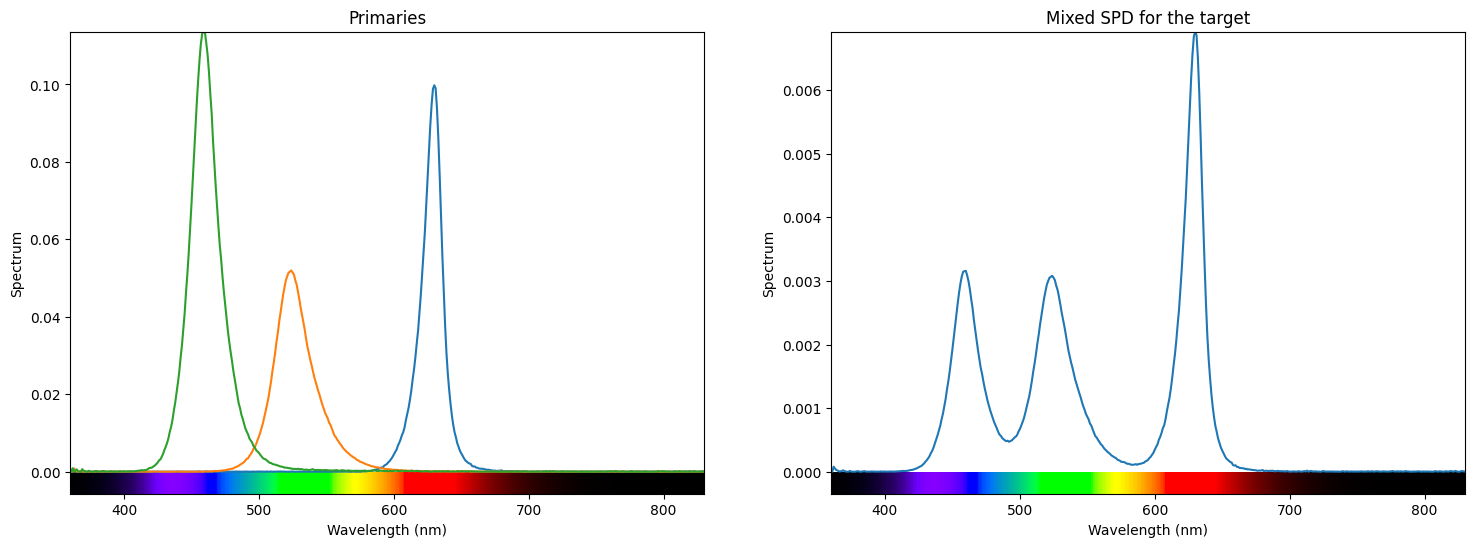

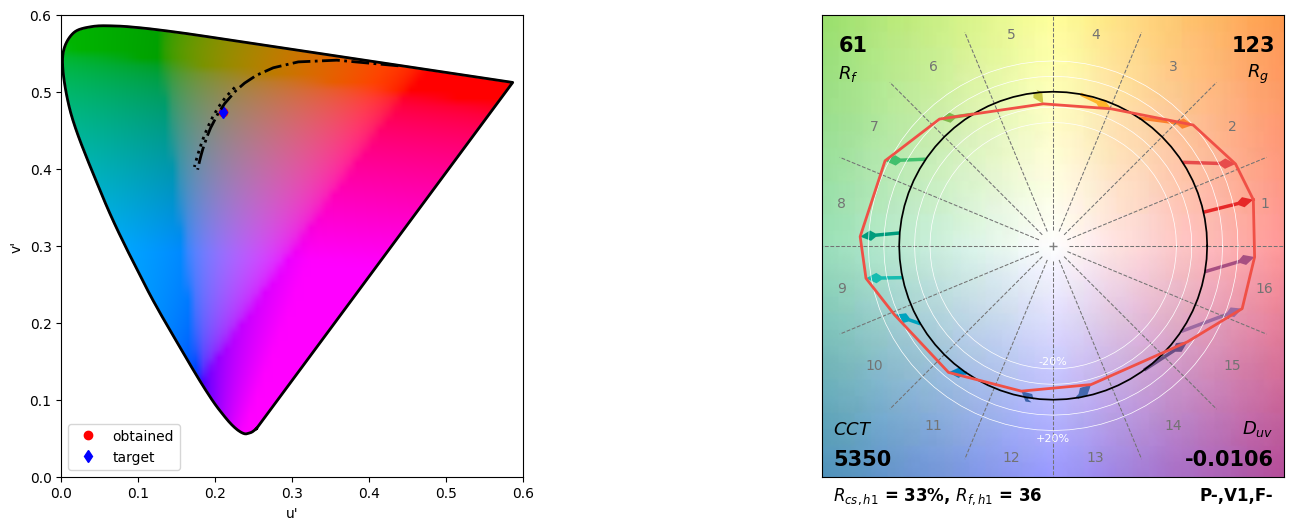


------------Measured------------
Luminance [cd/m2] : 343.7
xyz : [ 421.9, 343.7, 193.4 ]
Target xyz : [ 100.0, 100.0, 100.0 ]


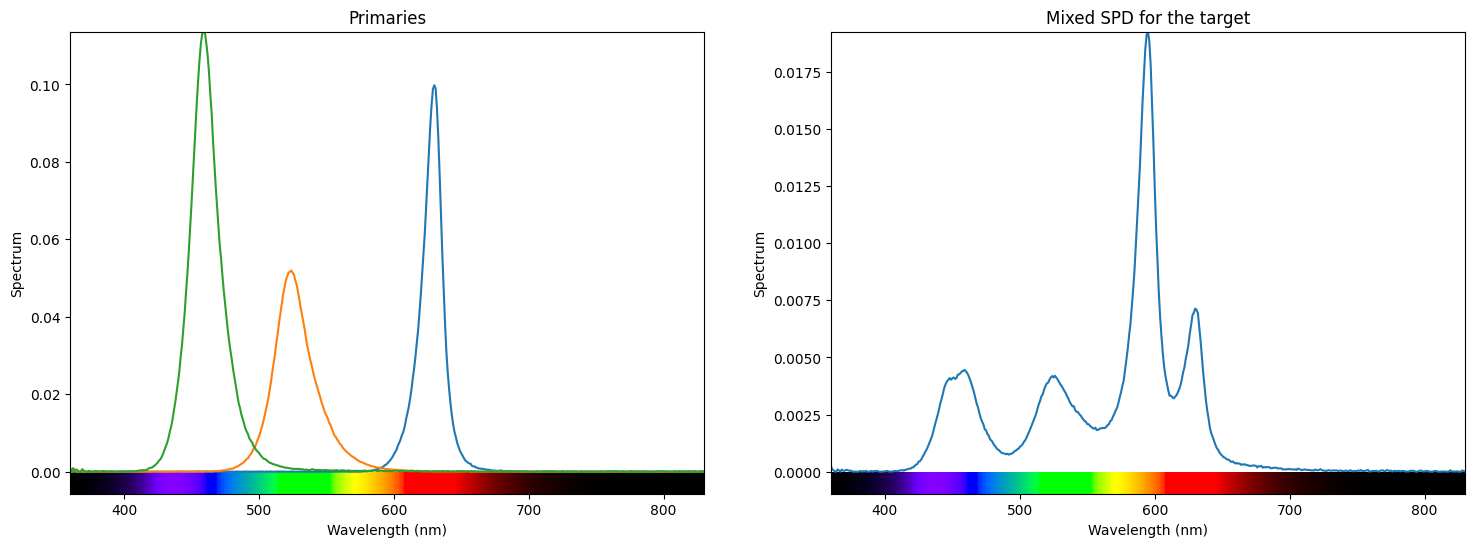

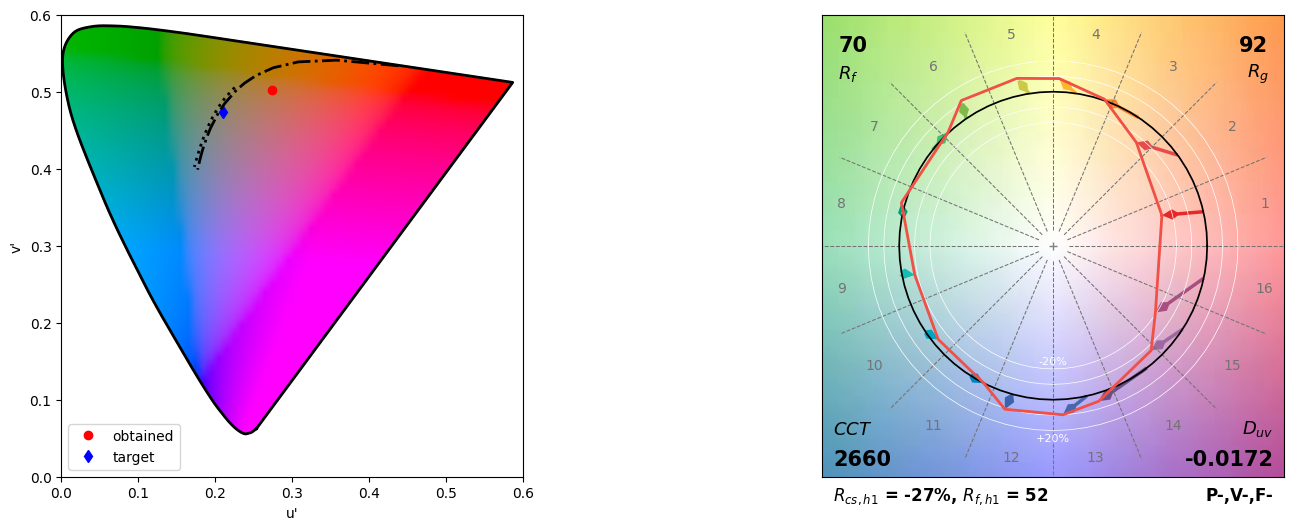

In [146]:
xyz_t = np.array([[100, 100, 100]])*1
channels_idx = [0, 1, 2]
color_mixing(xyz_t, channels_idx)

## 4-channels colormixing

507.8050098415597
Selected channels: ['R', 'G', 'B', 'A']
Optimized primary contributions: [2.4512e-01 2.6916e-01 1.3944e-01 1.7727e-01]
Output values of the light source: [128 136  85  98]

-----------Optimized------------
Luminance [cd/m2] : 500.0
xyz : [ 500.0, 500.0, 500.0 ]
Target xyz : [ 500.0, 500.0, 500.0 ]


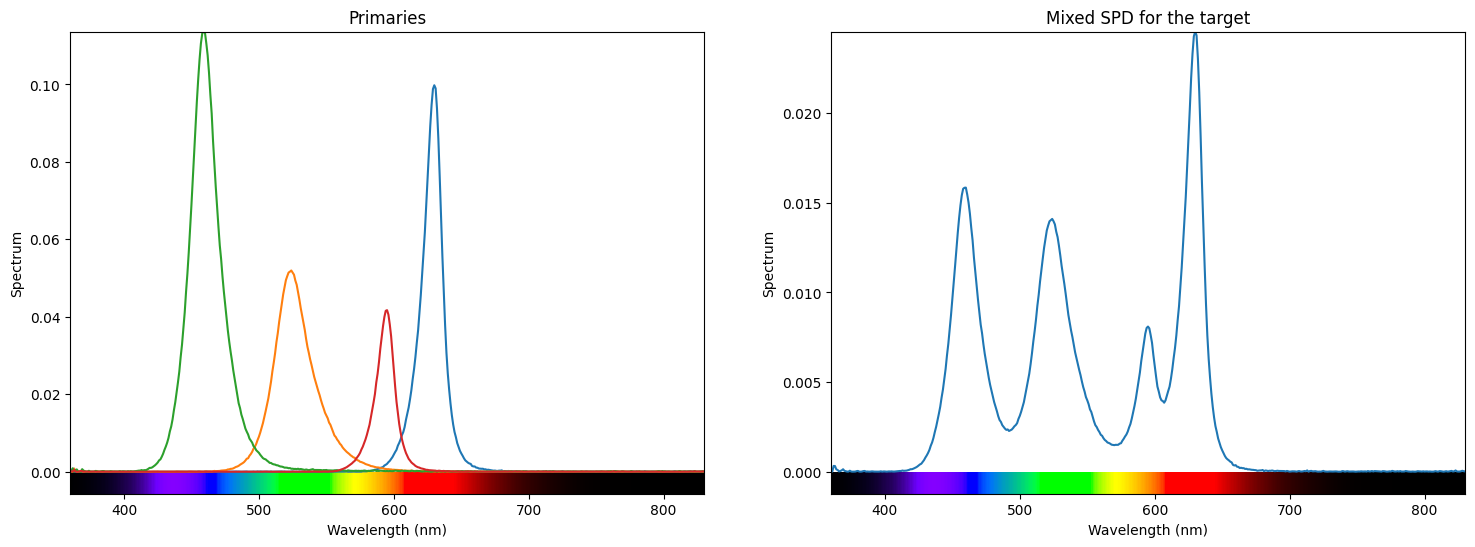

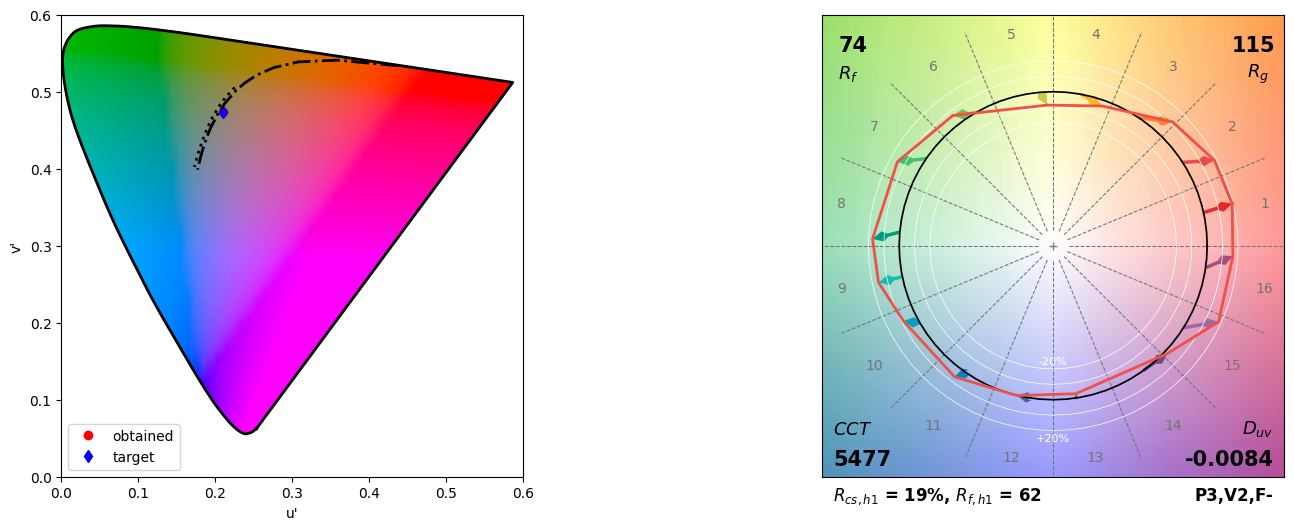


------------Measured------------
Luminance [cd/m2] : 487.4
xyz : [ 476.9, 487.4, 462.7 ]
Target xyz : [ 500.0, 500.0, 500.0 ]


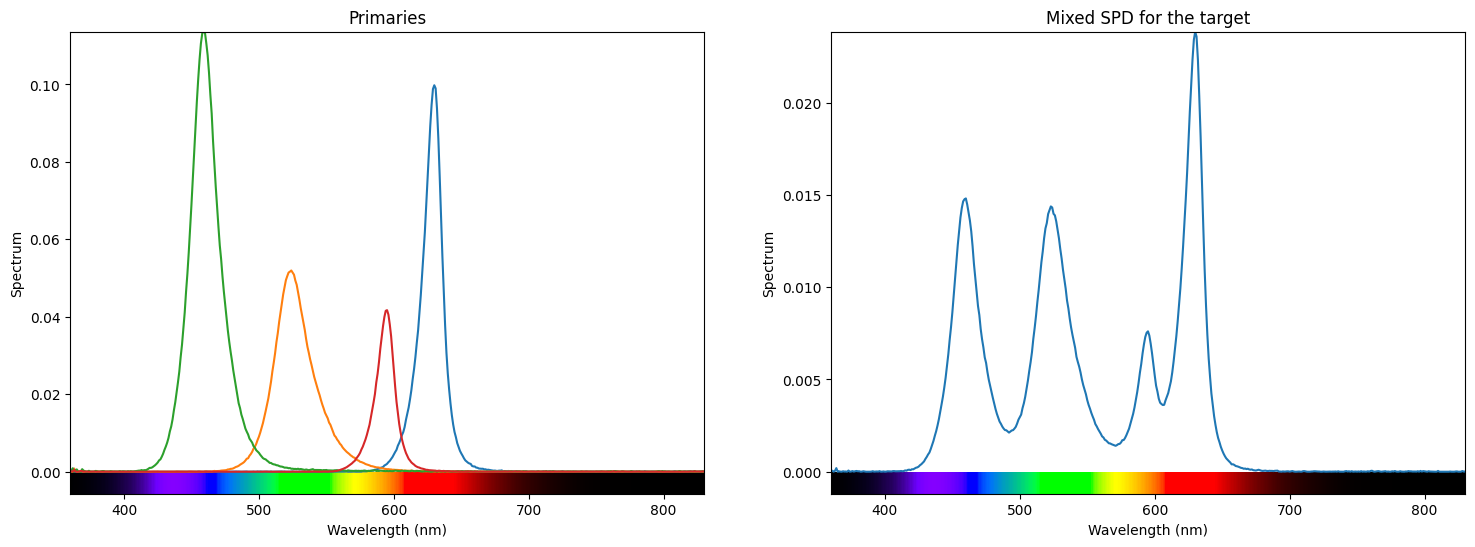

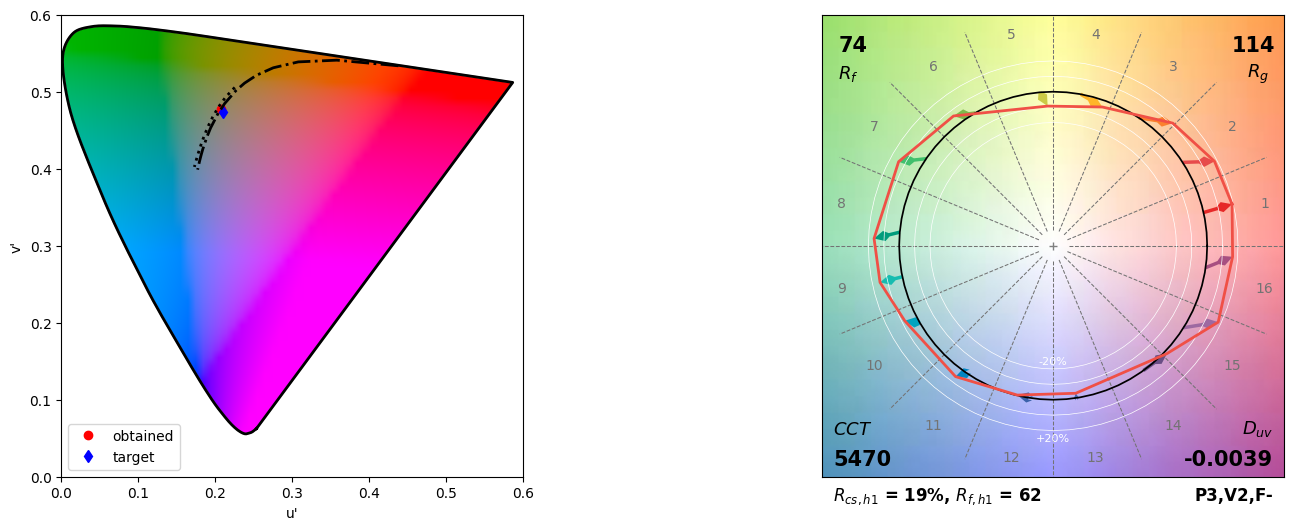

In [81]:
xyz_t = np.array([[100, 100, 100]])*5
channels_idx = [0, 1, 2, 4]
color_mixing(xyz_t,  channels_idx)


### 5 channels mixing

The weight was negative, so maynot achieve accurate result
The weight was negative, so maynot achieve accurate result
444.7665764730451
Selected channels: ['R', 'G', 'B', 'WH', 'A']
Optimized primary contributions: [-8.8458e-02 2.6128e-01 1.2689e-01 1.3092e-01 -1.4185e-02]
Output values of the light source: [  0 133  78  79   0]

-----------Optimized------------
Luminance [cd/m2] : 400.0
xyz : [ 200.0, 400.0, 600.0 ]
Target xyz : [ 200.0, 400.0, 600.0 ]


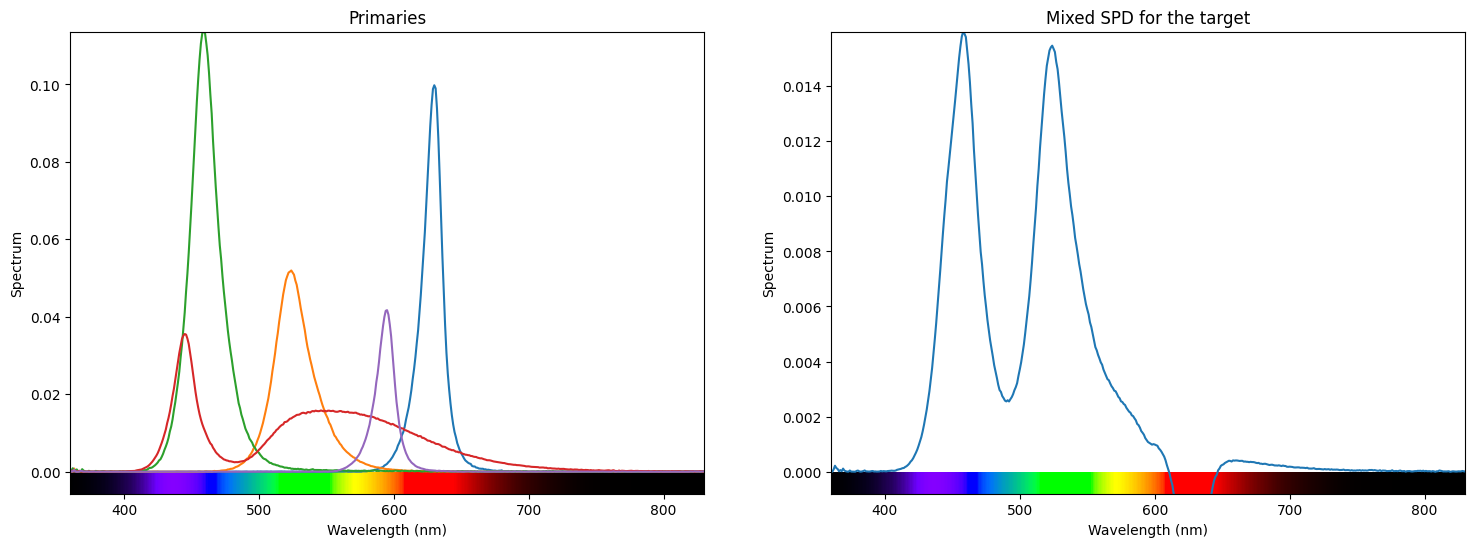

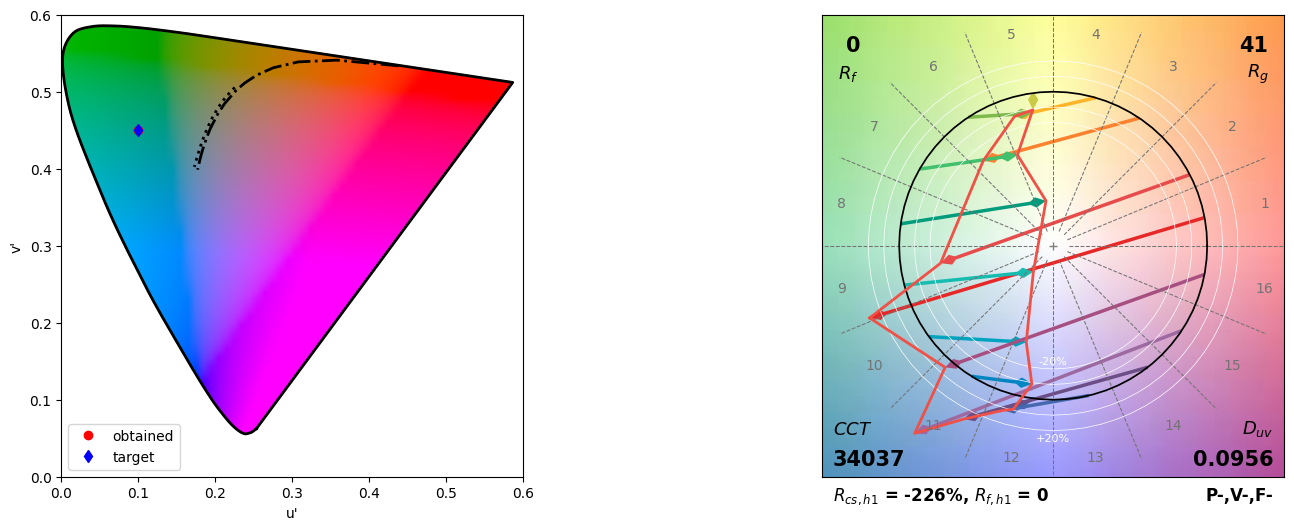


------------Measured------------
Luminance [cd/m2] : 437.3
xyz : [ 278.8, 437.3, 563.7 ]
Target xyz : [ 200.0, 400.0, 600.0 ]


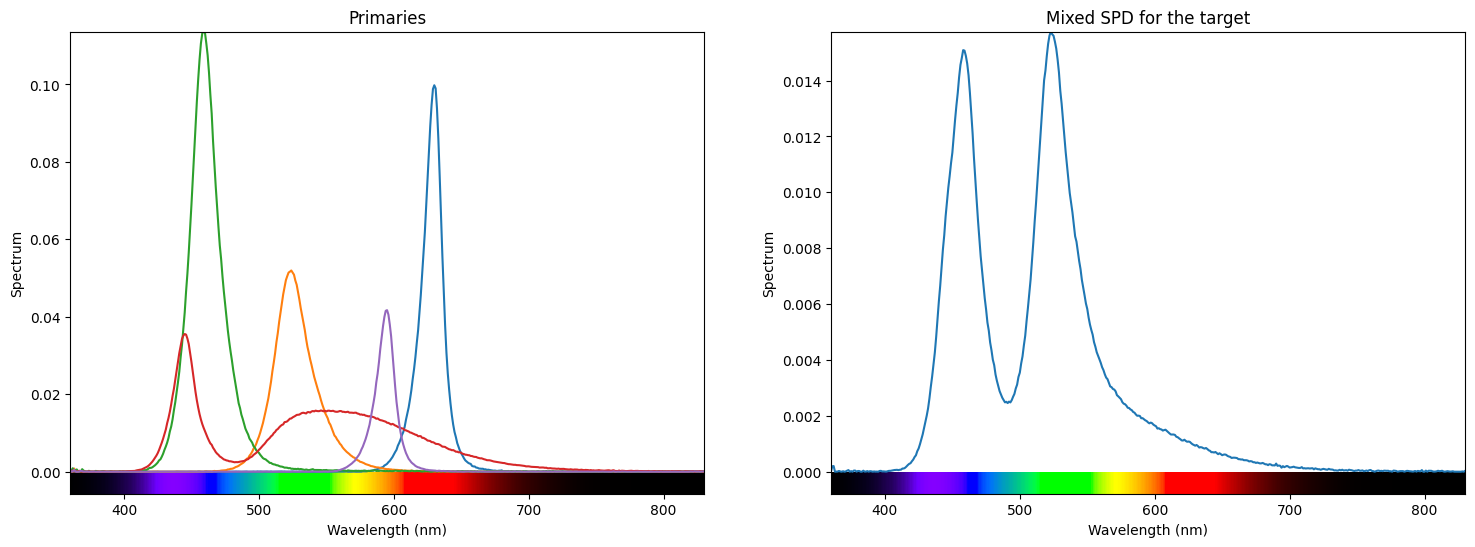

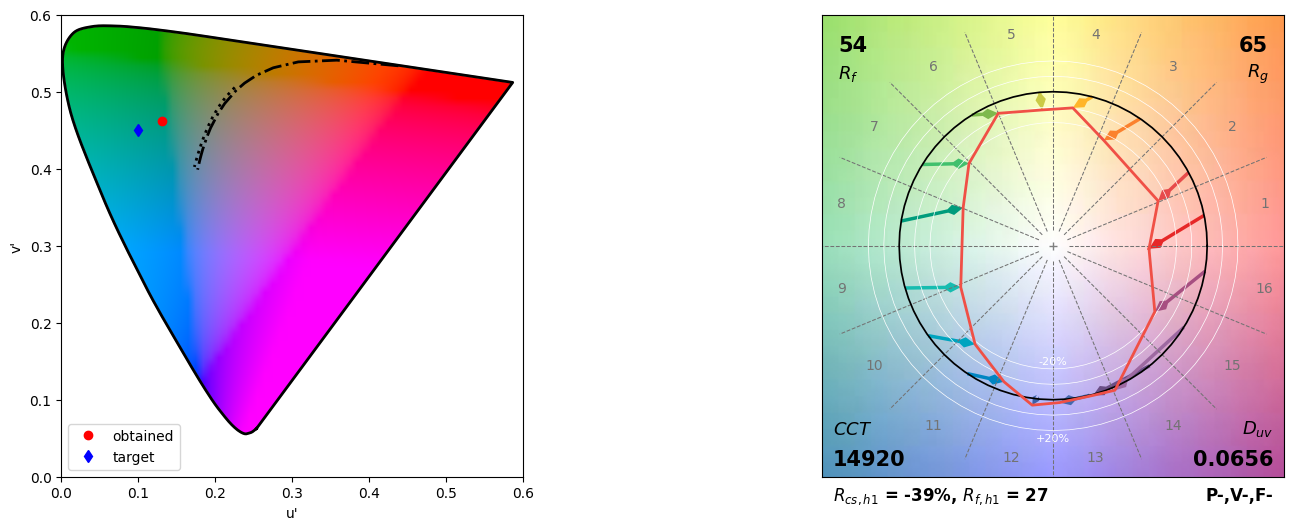

In [84]:
xyz_t = np.array([[100, 200, 300]])*2
channels_idx = [0, 1, 2, 3, 4]
color_mixing(xyz_t,  channels_idx)

### Multi-objective optimizer

In [92]:
def spectralOptimization(channels_idx, xyz_t=None, Rf_Rg=None, CCT_Duv=None, LER=None, method='Nelder-Mead'):
    methods = ['Nelder-Mead', 'particleswarm', 'demo']
    if method not in methods:
        print('Specify correct method.', methods)
        return 
    # define function that calculates several objectives at the same time (for speed):
    def spd_to_cris(spd):
        Rf, Rg = lx.cri.spd_to_cri(spd, cri_type='ies-tm30', out='Rf,Rg')
        
        return np.vstack((Rf, Rg))

    def spd_to_chrom(spd):
        xyz = lx.spd_to_xyz(spd, relative=False, cieobs=cieobs)
        cct, duv = lx.xyz_to_cct(xyz, cieobs=cieobs, out='cct,duv')
        return np.vstack((cct.T, duv.T))

    def spd_to_LER(spd):
        LER = lx.spd_to_ler(spd, cieobs=cieobs)
        return np.vstack((LER))
    
    obj_fcn = []
    obj_tar_vals = []
    if Rf_Rg is not None:
        obj_fcn.append((spd_to_cris, 'Rf', 'Rg'))
        obj_tar_vals.append(Rf_Rg) 
    if CCT_Duv is not None:
        obj_fcn.append((spd_to_chrom, 'cct', 'duv'))
        obj_tar_vals.append(CCT_Duv) 
    if LER is not None:
        obj_fcn.append((spd_to_LER, 'LER'))
        obj_tar_vals.append((LER)) 
       

    spd_p = getPrimarySPD(channels_idx=channels_idx)

    # method='Nelder-Mead','particleswarm', 'demo'

    so4 = spb.SpectralOptimizer(target = xyz_t,
                                tar_type = None if xyz_t is None else 'xyz',
                                wlr = [360,830,1], 
                                cieobs = cieobs, 
                                out = 'spds,primss,Ms,results',
                                optimizer_type = 'no-mixer' if xyz_t is None else '3mixer',
                                prim_constructor = None, 
                                prims = spd_p,
                                obj_fcn = spb.ObjFcns(f = obj_fcn,
                                                    ft = obj_tar_vals),
                                                    # fw = obj_fcn_weights),
                                minimizer = spb.Minimizer(method=method),
                                verbosity = 0)

    # start optimization:
    start_time = time.time()
    S, M = so4.start(out='spds,Ms')
    print('Running time for the optimization: {:.2f} sec'.format(time.time()-start_time))

    output = getDriverValues(channels_idx, M)
    print('Optimized primary contributions:', M[0])
    print('Output values of the light source:', output)

    def _result(spd):
        xyz = lx.spd_to_xyz(spd, relative=False, cieobs=cieobs)
        Yxy = lx.xyz_to_Yxy(xyz)
        cct, duv = lx.xyz_to_cct(xyz, cieobs=cieobs, out='cct,duv')
        Rf, Rg = spd_to_cris(spd)
        _LER = spd_to_LER(spd)

        print('Results (optim,target):')
        print("Rf: ({:1.2f}, {:1.2f})".format(Rf[0], np.nan if Rf_Rg is None else Rf_Rg[0]))
        print("Rg: ({:1.2f}, {:1.2f})".format(Rg[0], np.nan if Rf_Rg is None else Rf_Rg[1]))

        print("CCT [K]: ({:1.1f}, {:1.1f})".format(cct[0, 0], np.nan if CCT_Duv is None else CCT_Duv[0]))
        print("Duv: ({:1.4f}, {:1.4f})".format(
            duv[0, 0], np.nan if CCT_Duv is None else CCT_Duv[1]))
        print("LER [lm/W]: ({:1.1f}, {:1.1f})".format(_LER[0,0], np.nan if LER is None else LER))

    print('\n------Optimized Result-------')
    _result(S)
    showMixedSPD(spd_p, S)
    evaluate(S, xyz_t)
    
    if dmx is not None:
        print('\n------Measured Result-------')
        spd_measured = measureSPD(channels_idx, output)
        _result(spd_measured)
        showMixedSPD(spd_p, spd_measured)
        evaluate(spd_measured, xyz_t)





Running time for the optimization: 6.27 sec
Optimized primary contributions: [3.0320e-02 1.8227e-01 1.1512e-01 8.2248e-02 4.5780e-01]
Output values of the light source: [ 17 104  71  51 176]

------Optimized Result-------
Results (optim,target):
Rf: (80.03, 80.00)
Rg: (91.59, 95.00)
CCT [K]: (5482.0, nan)
Duv: (-0.0041, nan)
LER [lm/W]: (364.3, 400.0)
Luminance [cd/m2] : 500.0
xyz : [ 500.0, 500.0, 500.0 ]
Target xyz : [ 500.0, 500.0, 500.0 ]


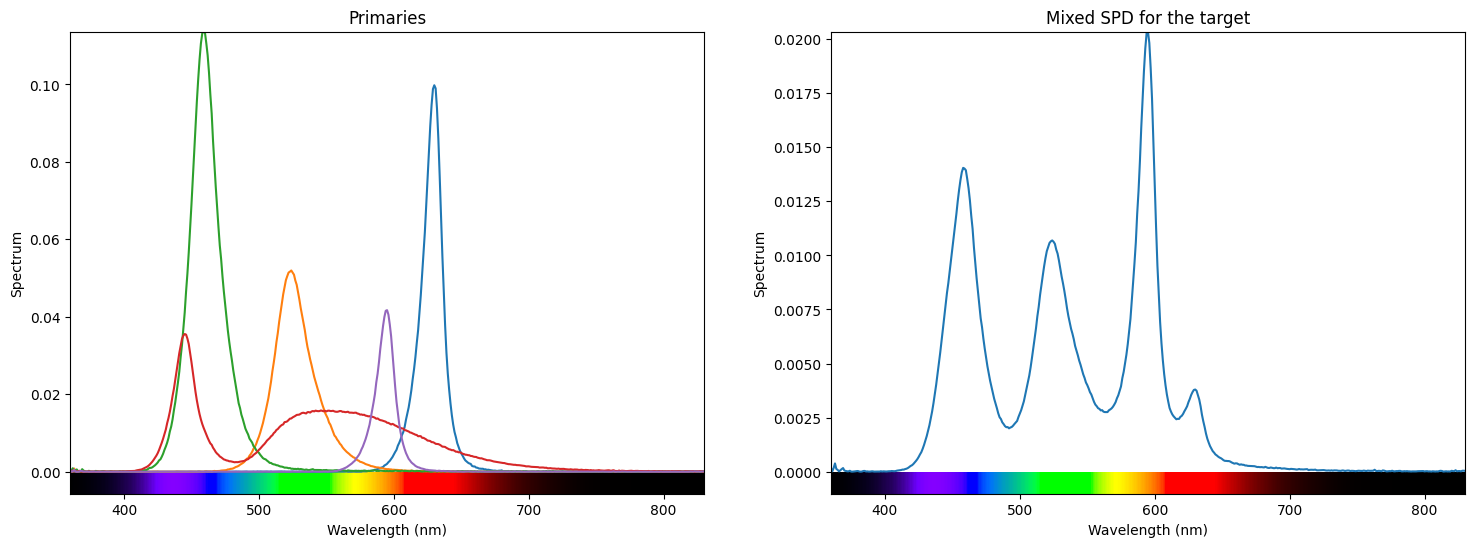

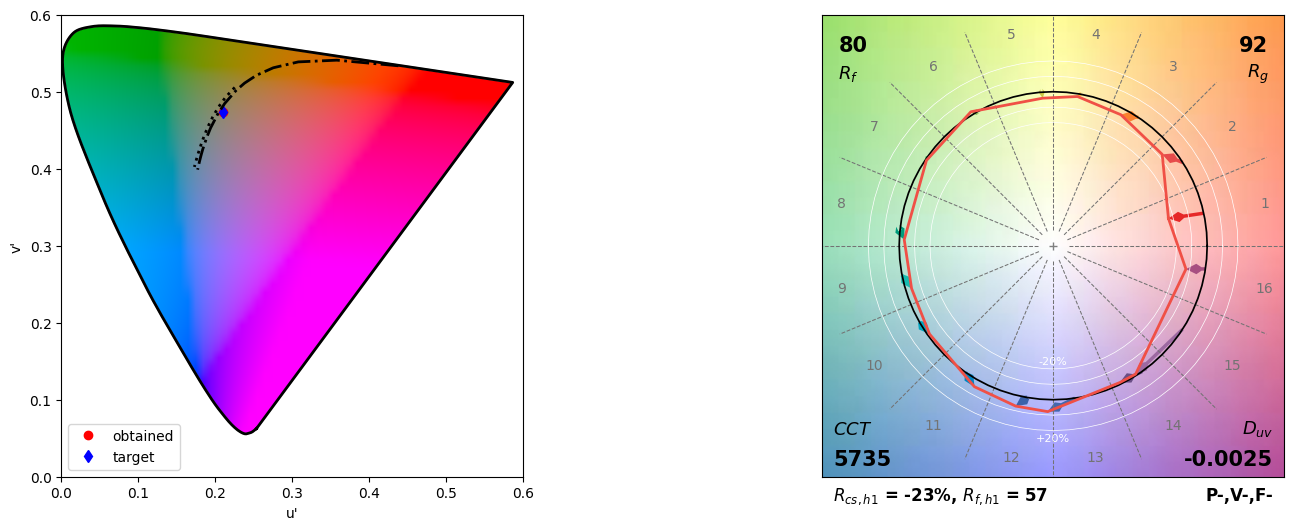


------Measured Result-------
Results (optim,target):
Rf: (81.38, 80.00)
Rg: (92.45, 95.00)
CCT [K]: (5601.1, nan)
Duv: (-0.0009, nan)
LER [lm/W]: (365.4, 400.0)
Luminance [cd/m2] : 482.6
xyz : [ 473.0, 482.6, 473.4 ]
Target xyz : [ 500.0, 500.0, 500.0 ]


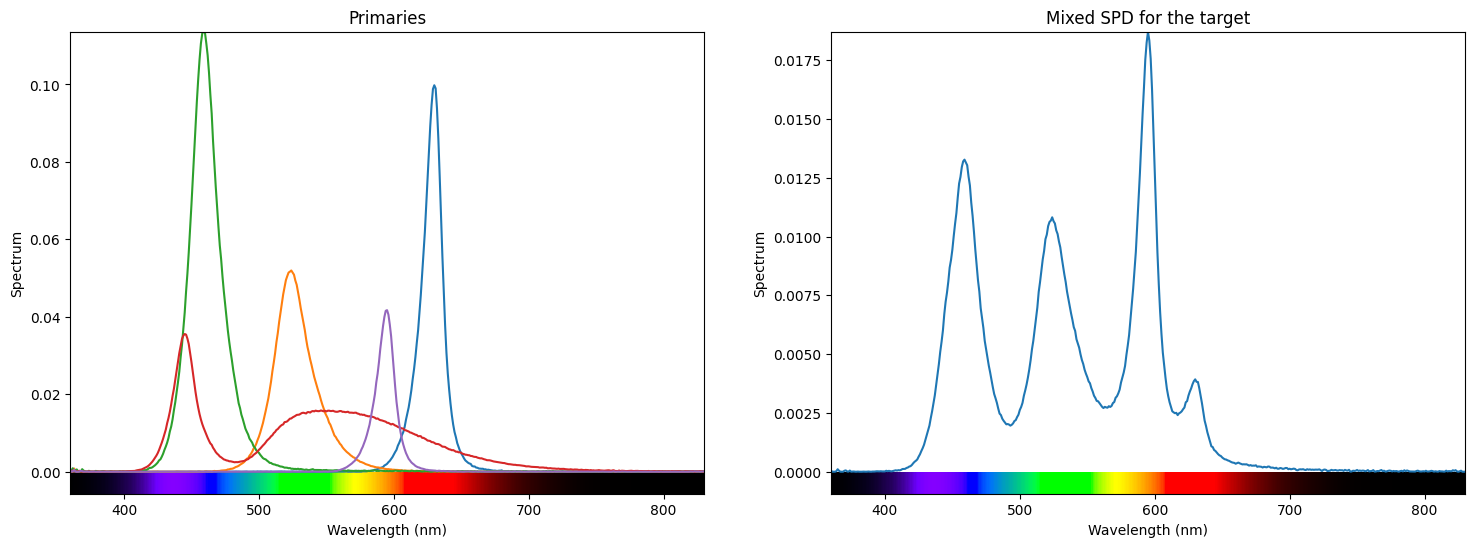

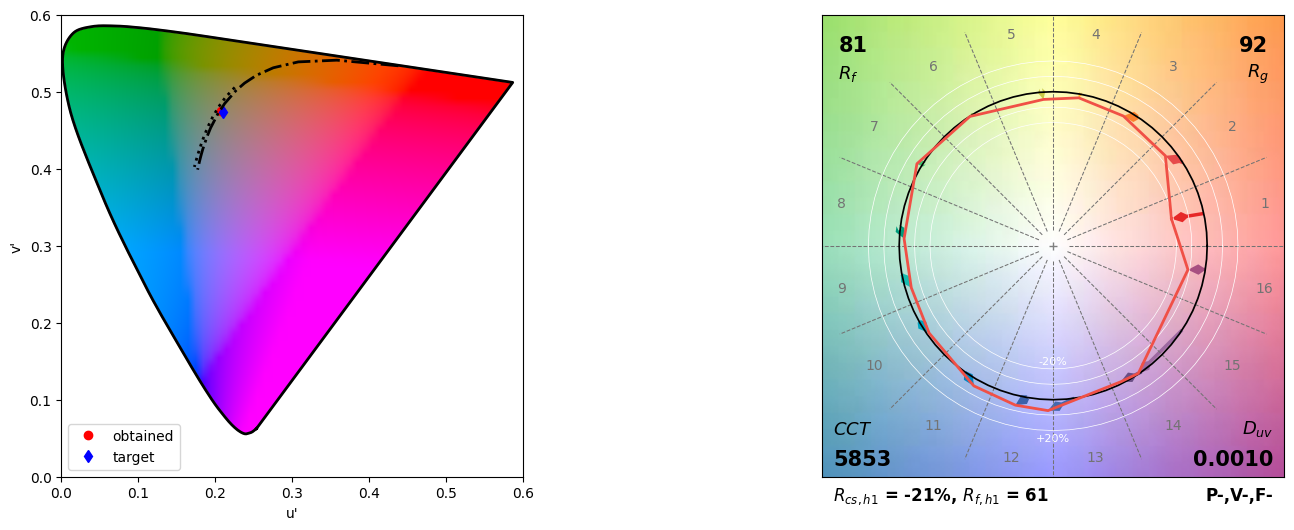

In [102]:
xyz_t = np.array([[100, 100, 100]])*5
channels_idx = [0, 1, 2, 3, 4]
# spectralOptimization(xyz_t, channels_idx)
# spectralOptimization(channels_idx, Rf_Rg=(80, 95))

# spectralOptimization(channels_idx, xyz_t=None,
#                      Rf_Rg=(80, 95),  CCT_Duv=(6000, 0.05), method='particleswarm')

# spectralOptimization(channels_idx, xyz_t=None,
#                      Rf_Rg=(80, 95),  CCT_Duv=(6000, 0.05), LER = 100, method='particleswarm')

spectralOptimization(channels_idx, xyz_t=xyz_t,
                     Rf_Rg=(80, 95),LER = 400,  method='Nelder-Mead')

In [106]:
if dmx is not None:
    dmx.set_channel(1, 0)
    dmx.submit()
    dmx.close()